In this activity we will manually implement a simple Recursive Feature Elimination (RFE) technique to remove redundant or insignificant input features.

Train your model using one feature at a time and plot the significance (importance) of each feature.

Rank the features by their importance.

Iteratively remove one feature at a time (starting with the least significant feature) and repeat the training.

**Draw a plot to report your findings**
* X-axis represent feature removal
* Y-axis is accuracy or MAE

In [0]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import *
from google.colab import files
import time

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


In [0]:
uploaded = files.upload()
file_name = "heart.csv"

Saving heart.csv to heart.csv


### Reading Data and Prepare Dataset

In [0]:
import pandas as pd
dataset = pd.read_csv(file_name, delimiter=',')
print(dataset.shape)
dataset.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

### Percent to Split

In [0]:
# Index for 30%
index_30percent = int(0.3 * len(dataset_np[:, 0]))
print(index_30percent)

90


### Validation Dataset

In [0]:
# Split into training and validation
XVALID = X[:index_30percent, :]
YVALID = Y[:index_30percent]

XTRAIN = X[index_30percent:, :]
YTRAIN = Y[index_30percent:]

## Mean normalization
min = XTRAIN.min(axis = 0) 
max = XTRAIN.max(axis = 0) 
mean = XTRAIN.mean(axis = 0)
XTRAIN = (XTRAIN - mean) / (max - min)
XVALID = (XVALID - mean) / (max - min)

## Rescaling
Ymax = YTRAIN.max()
YTRAIN = YTRAIN / Ymax
YVALID = YVALID / Ymax

In [0]:
def learning_curves(model_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(model_history.history['loss'])
    ax1.plot(model_history.history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['training loss data', 'validation loss data'], loc='upper right')

    ax2.plot(model_history.history['mean_absolute_error'])
    ax2.plot(model_history.history['val_mean_absolute_error'])
    ax2.set_ylabel('error')
    ax2.set_xlabel('epoch')
    ax2.legend(['training error data', 'validation error data'], loc='upper right')

    fig.show()

## Early Stopping Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# File name must be in quotes
callback_a = ModelCheckpoint(filepath = "your_model.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)

# The patience value can be 10, 20, 100, etc. depending on when your model starts to overfit
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

modelES = Sequential()
modelES.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
modelES.add(Dense(7, activation='relu'))
modelES.add(Dense(1, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
modelES.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

start_time = time.time()
historyES = modelES.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b], verbose=0) 
callBackTime = time.time() - start_time

### Learning Curves of Early Stopping Model

90/90 [==============================] - 0s 65us/sample - loss: 0.0186 - mean_absolute_error: 0.1114
Last Val Loss: 0.018557189032435417
Last Val MAE: 0.11135335
{'batch_size': 100, 'epochs': 1024, 'steps': None, 'samples': 213, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']}
Time (sec): 11.47965407371521


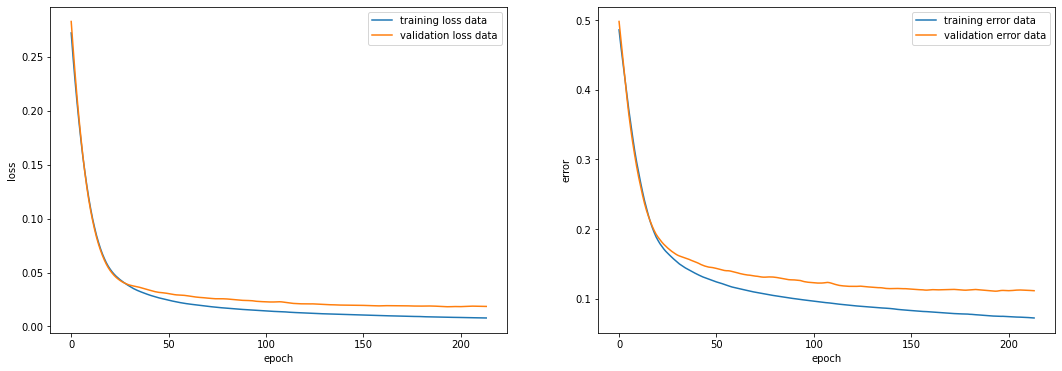

In [0]:
modelES.evaluate(XVALID, YVALID)
print("Last Val Loss: %s" % historyES.history['val_loss'][-1])
print("Last Val MAE: %s" % historyES.history['val_mean_absolute_error'][-1])
print(historyES.params)
learning_curves(historyES)

print("Time (sec): %s" % callBackTime)

## **Iterative feature removal & selection**

### Significance (importance) of each feature

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

importance_feature_columns = []
importance_feature = []
for index in range(1, dataset.shape[1]):
    ## Get the column
    X = dataset[dataset.columns[index]].values
    Y = dataset['age'].values

    ## Index for 30%
    index_30percent = int(0.3 * len(dataset_np[:, 0]))

    ## Split into training and validation
    XVALID = X[:index_30percent]
    YVALID = Y[:index_30percent]
    
    XTRAIN = X[index_30percent:]
    YTRAIN = Y[index_30percent:]

    ## Mean normalization
    min = XTRAIN.min(axis = 0) 
    max = XTRAIN.max(axis = 0) 
    mean = XTRAIN.mean(axis = 0)
    XTRAIN = (XTRAIN - mean) / (max - min)
    XVALID = (XVALID - mean) / (max - min)

    ## Rescaling
    Ymax = YTRAIN.max()
    YTRAIN = YTRAIN / Ymax
    YVALID = YVALID / Ymax

    ## Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(13, input_dim=1, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))

    ## Compile Model
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    ## Store MAE
    prediction = model.predict(XVALID, verbose=0)
    mae = mean_absolute_error(YVALID, prediction)
    importance_feature_columns.append(dataset.columns[index])
    importance_feature.append(mae)
# ~~~

print(importance_feature_columns)
print(importance_feature)

['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
[0.0994963967266881, 0.10124179126552346, 0.09715580720062036, 0.09835895059944748, 0.10293217100966372, 0.10200832356278171, 0.08732371887603363, 0.09892957915819396, 0.10034913188451296, 0.0993107539320749, 0.0970998420085742, 0.10007469795138976, 0.09760264019773465]


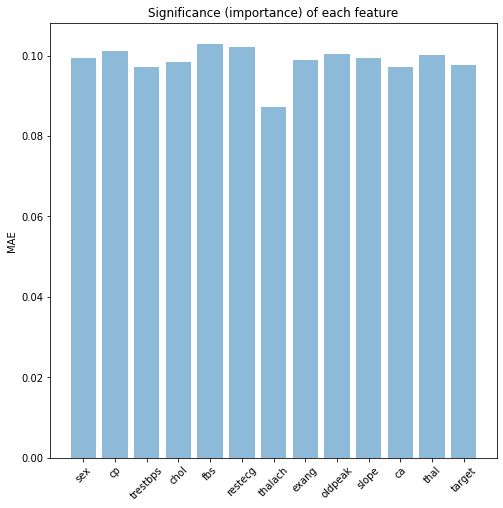

In [0]:
y_pos = np.arange(len(importance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, importance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, importance_feature_columns, fontsize=10, rotation=45)
plt.ylabel('MAE')
plt.title('Significance (importance) of each feature')

plt.show()

In [0]:
# Ranking the features by their importance
import operator

dictionary_mae = {}
for index, name in enumerate(importance_feature_columns):
    dictionary_mae[name] = importance_feature[index]

dictionary_mae = sorted(dictionary_mae.items(), key=operator.itemgetter(1))
print(dictionary_mae)

[('thalach', 0.08732371887603363), ('ca', 0.0970998420085742), ('trestbps', 0.09715580720062036), ('target', 0.09760264019773465), ('chol', 0.09835895059944748), ('exang', 0.09892957915819396), ('slope', 0.0993107539320749), ('sex', 0.0994963967266881), ('thal', 0.10007469795138976), ('oldpeak', 0.10034913188451296), ('cp', 0.10124179126552346), ('restecg', 0.10200832356278171), ('fbs', 0.10293217100966372)]


### Performance drop after removing less important features

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

performance_feature_columns = []
performance_feature = []
for index in range(1, dataset.shape[1]):
    # Get the column
    X = dataset.drop([dataset.columns[index], axis='columns').values
    Y = dataset['age'].values

    # Index for 30%
    index_30percent = int(0.3 * len(dataset_np[:, 0]))

    # Split into training and validation
    XVALID = X[:index_30percent]
    YVALID = Y[:index_30percent]
    
    XTRAIN = X[index_30percent:]
    YTRAIN = Y[index_30percent:]

    ## Mean normalization
    min = XTRAIN.min(axis = 0) 
    max = XTRAIN.max(axis = 0) 
    mean = XTRAIN.mean(axis = 0)
    XTRAIN = (XTRAIN - mean) / (max - min)
    XVALID = (XVALID - mean) / (max - min)

    ## Rescaling
    Ymax = YTRAIN.max()
    YTRAIN = YTRAIN / Ymax
    YVALID = YVALID / Ymax

    # Callback
    callback_a = ModelCheckpoint(filepath = "feature_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    # Model
    model = Sequential()
    model.add(Dense(13, input_dim=len(XTRAIN[0, :]), activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile Model
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    # Store MAE
    prediction = model.predict(XVALID, verbose=0)
    mae = mean_absolute_error(YVALID, prediction)
    performance_feature_columns.append(dataset.columns[index])
    performance_feature.append(mae)
# ~~~

print(performance_feature_columns)
print(performance_feature)

['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
[0.03363496797941465, 0.03236306270135602, 0.029235253318563685, 0.04097344113720789, 0.024651884976747584, 0.016553893620833697, 0.031272096843774536, 0.030172104357296947, 0.028799943899007408, 0.04188209849518615, 0.033934885813904365, 0.025716133895202463, 0.026238738372384385]


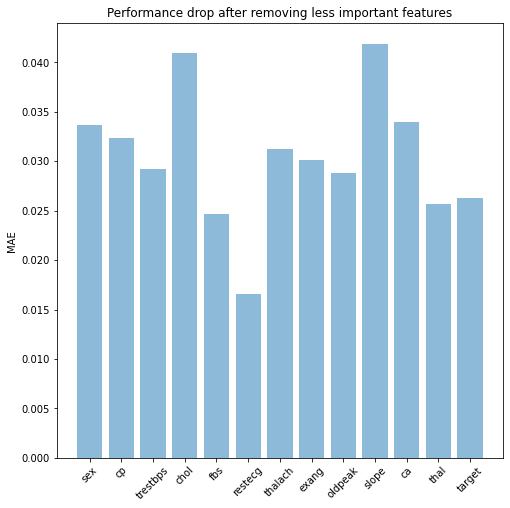

In [0]:
y_pos = np.arange(len(performance_feature_columns))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, performance_feature, align='center', alpha=0.5)
plt.xticks(y_pos, performance_feature_columns, fontsize=10, rotation=45)
plt.ylabel('MAE')
plt.title('Performance drop after removing less important features')

plt.show()

In [0]:
# Ranking the features by their performance
import operator

dictionary_mae = {}
for index, name in enumerate(performance_feature_columns):
    dictionary_mae[name] = performance_feature[index]

dictionary_mae = sorted(dictionary_mae.items(), key=operator.itemgetter(1))
print(dictionary_mae)

[('restecg', 0.016553893620833697), ('fbs', 0.024651884976747584), ('thal', 0.025716133895202463), ('target', 0.026238738372384385), ('oldpeak', 0.028799943899007408), ('trestbps', 0.029235253318563685), ('exang', 0.030172104357296947), ('thalach', 0.031272096843774536), ('cp', 0.03236306270135602), ('sex', 0.03363496797941465), ('ca', 0.033934885813904365), ('chol', 0.04097344113720789), ('slope', 0.04188209849518615)]
